<h1 align="center"> Image Captioning With Attention</h1>

In this notebook you will teach network to use attention during captioning images.

Here is what we need to do:
1. Take pretrained VGG19 to build feature vectors for positions of images.
2. Stack LSTM with attention on top of that.
3. Train the model, draw attention maps.

This assignment is based on Alexander Panin's captioning assignment (https://github.com/yandexdataschool/Practical_DL/blob/spring2019/homework04/homework04_basic_part2_image_captioning.ipynb) and on the paper "Show, Attend and Tell" (https://arxiv.org/abs/1502.03044).

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
import json
import numpy as np
from tqdm import tqdm
import h5py
import sys

import matplotlib.pyplot as plt
%matplotlib inline

## Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained VGG19 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py).

The whole process takes anywhere between a day on CPU and 30min on 1x GeForce GTX 1060. If you want to play with that yourself, [you're welcome](https://drive.google.com/file/d/1NLtoLqZzeES_flgs9kmmeZD_tsCTenH1/view?usp=sharing).

Please either download data from [here](https://drive.google.com/file/d/1sK1jLzW8RRAW4tnvD01ESS7Dj4eDuLuX/view?usp=sharing) or generate it manually using the above script.

In [5]:
f = h5py.File('img_codes.hdf5', 'r')
img_codes = f['data']

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'img_codes.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
captions = json.load(open('captions_tokenized.json'))

In [8]:
print("Each image code is a 512x9x9-unit tensor [ shape: %s x %s ]" % (str(len(img_codes)), str(img_codes[0].shape)))
print(img_codes[0][:3].round(2), end='\n\n')

print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 512x9x9-unit tensor [ shape: 118287 x (512, 9, 9) ]
[[[0.   0.   0.   0.   0.07 0.69 0.   0.   0.  ]
  [0.   0.24 0.   0.   0.63 1.94 1.21 0.72 0.46]
  [0.77 0.76 0.   0.   0.   0.88 1.65 2.37 1.14]
  [0.21 0.   0.   0.   2.8  3.3  2.93 6.29 3.48]
  [0.   0.   0.   0.   3.29 3.81 2.24 2.76 0.01]
  [0.   0.   0.   1.18 0.32 0.08 0.   0.   0.  ]
  [1.02 1.76 0.89 1.77 0.   0.   0.   0.   0.  ]
  [0.   1.36 0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.09 0.3  0.  ]]

 [[0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.17 0.   0.   0.   0.   0.  ]
  [0.   0.95 0.   0.   0.   0.   0.   0.   0.  ]
  [0.34 1.5  0.   0.   0.36 0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.23 0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.52 0.   0.   0.  ]
  [0.   0.34 0.   0.   0.   0.   0.86 0.34 0.  ]
  [0.   0.47 0.26 0.41 0.   0.   1.08 0.38 0.  ]]

 [[1.09 3.03 2.15 0.65 0.   0.   1.06 0.2

As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [9]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [10]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
# <YOUR CODE HERE>

In [11]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [12]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [13]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   14,  287,  141,   14, 1130,  256,   62,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,  287,   62,   14, 1130,  256,  141,   14, 1291,    2,
           3,    3,    3],
       [   1,   14,   90,  141,   14, 1291,   62,   44,    5,   14, 1287,
          13,    2,    3],
       [   1,   14, 1238, 1370,   14, 1291,   62,   14,   73,   74,   13,
           2,    3,    3],
       [   1,   14,   90,   18,   71,  342,  141,   14, 1291,   62,   14,
        1287,   13,    2]], dtype=int32)

## Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on the features from the convolutional part. 

We'll unbox the inception net later to save memory, for now just pretend that it's available.

In [14]:
import torch, torch.nn as nn
import torch.nn.functional as F

### Attention

There are $K$ objects that you can pay attention to.
Each object is characterized by the key $k_i$ and the value $v_i$.
The attention layer proceeds queries.
For the query $q$, the layer returns a weighted sum of the values of the objects, with weights proportional to the degree of key matching the query:
$$w_i = \frac{\exp(score(q, k_i))}{\sum_{j=1}^K\exp(score(q, k_j))}$$
$$a = \sum_{i=1}^K w_i v_i$$

Here we use $score(q, k) = \frac{q^Tk}{\sqrt{dim(k)}}$, where $dim(k)$ is the dimensionality of the key (which also equals the dimensionality of the query).
For more information see the paper Vaswani et al. "Attention Is All You Need", 2017.

_Hint:_ It is recommended to pay attention to the function torch.bmm, it may be useful below.

#### Score function layer

In [15]:
class ScaledDotProductScore(nn.Module):
    """
    Vaswani et al. "Attention Is All You Need", 2017.
    """
    def __init__(self):
        super().__init__()

    def forward(self, queries, keys):
        """
        queries:  [batch_size x num_queries x dim]
        keys:     [batch_size x num_objects x dim]
        Returns a tensor of scores with shape [batch_size x num_queries x num_objects].
        """
        # <YOUR CODE HERE>
        return result

Test for ScaledDotProductScore

In [16]:
q = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0],
]], dtype=torch.float32)
o = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
]], dtype=torch.float32)
print(ScaledDotProductScore()(q, o))

tensor([[[0.4472, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4472, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])


#### Attention layer

In [17]:
class Attention(nn.Module):
    def __init__(self, scorer):
        super().__init__()
        self.scorer = scorer

    def forward(self, queries, keys, values):
        """
        queries:         [batch_size x num_queries x query_feature_dim]
        keys:            [batch_size x num_objects x key_feature_dim]
        values:          [batch_size x num_objects x obj_feature_dim]
        Returns matrix of responses for queries with shape [batch_size x num_queries x obj_feature_dim].
        Saves detached weights as self.attention_map.
        """
        scores = self.scorer(queries, keys)
        # <YOUR CODE HERE>
        weights = # <YOUR CODE HERE>
        self.attention_map = weights.detach()
        # <YOUR CODE HERE>
        return result

Tests for Attention layer

In [18]:
attn = Attention(ScaledDotProductScore())

In [19]:
q = torch.randn(2, 3, 5)
k = torch.randn(2, 4, 5)
v = torch.randn(2, 4, 7)
assert attn(q, k, v).shape == (2, 3, 7)

In [20]:
q = torch.tensor([[
    [0.01],
    [1],
    [100],
]], dtype=torch.float32)
o = torch.tensor([[
    [-1],
    [0],
    [1],
]], dtype=torch.float32) * 1000
a = attn(q, o, o)
assert torch.isnan(attn.last_weights).sum() == 0
assert torch.isnan(a).sum() == 0

In [21]:
q = torch.tensor([[
    [0, 1],
    [1, 0],
]], dtype=torch.float32)
k = torch.tensor([[
    [0, 0],
    [0, 1],
    [1, 0],
]], dtype=torch.float32)
v = torch.tensor([[
    [0],
    [1],
    [2],
]], dtype=torch.float32)
a = attn(q, k, v)
print('Attention map:\n', attn.last_weights)
print('Responses:\n', a)

Attention map:
 tensor([[[0.2483, 0.5035, 0.2483],
         [0.2483, 0.2483, 0.5035]]])
Responses:
 tensor([[[1.0000],
         [1.2552]]])


### Language model

In [22]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_channels=512):
        """ A recurrent 'head' network for image captioning. Read scheme below. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_channels, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_channels, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = # <YOUR CODE> 
            
        # attention: create attention over image spatial positions
        # The query is previous lstm hidden state, the keys are transformed cnn features,
        # the values are cnn features
        self.attention = # <YOUR CODE>
        
        # attention: create transform from cnn features to the keys
        # Hint: one linear layer shoud work
        # Hint: the dimensionality of keys should be lstm_units as lstm
        #       hidden state is the attention query
        self.cnn_to_attn_key = # <YOUR CODE>
                
        # lstm: create a recurrent core of your network. Use LSTMCell
        self.lstm = # <YOUR CODE>

        # create logits: MLP that takes attention response, lstm hidden state
        # and the previous word embedding as an input and computes one number per token
        # Hint: I used an architecture with one hidden layer, but you may try deeper ones
        self.logits_mlp = # <YOUR CODE>
        
    def forward(self, image_features, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_features: torch tensor containing VGG features for each position.
                               shape: [batch, cnn_channels, width * height]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_features.mean(2))
        initial_hid = self.cnn_to_h0(image_features.mean(2))
        
        image_features = image_features.transpose(1, 2)
        
        # compute embeddings for captions_ix
        captions_emb = # <YOUR CODE>
        
        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. In the recurrent loop over tokens:
        #   2.1. transform image vectors to the keys for attention
        #   2.2. use previous lstm state as an attention query and image vectors as values
        #   2.3. apply attention to obtain context vector
        #   2.4. store attention map
        #   2.5. feed lstm with current token embedding concatenated with context vector
        #   2.6. update lstm hidden and cell vectors
        #   2.7. store current lstm hidden state, attention response, and the previous word embedding
        # reccurent_out should be lstm hidden state sequence
        # of shape [batch, caption_length, lstm_units + cnn_channels + emb_size]
        # attention_map should be attention maps sequence
        # of shape [batch, caption_length, width * height]
        reccurent_out = # <YOUR_CODE>
        attention_map = # <YOUR CODE>
        
        # compute logits for next token probabilities
        # based on the stored in (2.7) values (reccurent_out)
        logits = # <YOUR_CODE>
        
        # return logits and attention maps from (2.4)
        return logits, attention_map

In [23]:
network = CaptionNet(n_tokens)

In [24]:
dummy_img_vec = torch.randn(len(captions[0]), 512, 81)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits, dummy_attention_map = network.forward(dummy_img_vec, dummy_capt_ix)
dummy_logits, dummy_attention_map = network.forward(dummy_img_vec, dummy_capt_ix)

print('logits shape:', dummy_logits.shape)
print('attention map shape:', dummy_attention_map.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)
assert dummy_attention_map.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], 81)

logits shape: torch.Size([5, 14, 10403])
attention map shape: torch.Size([5, 14, 81])


#### Train loss function

In [25]:
def compute_loss(network, image_features, captions_ix):
    """
    :param image_features: torch tensor containing VGG features. shape: [batch, cnn_channels, width * height]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones plus 
              attention regularizer. Scalar float tensor
    """
    
    if next(network.parameters()).is_cuda:
        image_features, captions_ix = image_features.cuda(), captions_ix.cuda()
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions, attnetion map and gates for captions_ix_next
    logits_for_next, attention_map = network.forward(image_features, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = # <YOUR CODE>

    # the regularizer for attention - this one requires the attention over each position to sum up to 1,
    # i. e. to look at the whole image during sentence generation process
    mask = (captions_ix_inp != pad_ix)
    masked_attention_map = attention_map * mask[:, :, None].float()
    regularizer = ((1 - masked_attention_map.sum(1)) ** 2).mean()
    
    return loss + regularizer

In [26]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.detach().cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

#### Optimizer
Create ~~adam~~ your favorite optimizer for the network.

In [27]:
# <YOUR CODE>

# Training

* First make train/val split without extra memory usage
* Implement the batch generator
* Than train the network as usual

In [28]:
from torch.utils.data import Dataset

class IdxDataset(Dataset):
    def __init__(self, dataset, idx):
        self.dataset = dataset
        self.idx = idx
    
    def __len__(self):
        return len(self.idx)
        
    def __getitem__(self, idx):
        return self.dataset[self.idx[idx]]

In [29]:
captions = np.array(captions)

np.random.seed(42)
perm = np.random.permutation(len(img_codes))
threshold = round(len(img_codes) * 0.1)
train_img_idx, val_img_idx = perm[threshold:], perm[: threshold]

train_img_idx.sort()
val_img_idx.sort()
train_img_codes = IdxDataset(img_codes, train_img_idx)
val_img_codes = IdxDataset(img_codes, val_img_idx)
train_captions = IdxDataset(captions, train_img_idx)
val_captions = IdxDataset(captions, val_img_idx)

In [30]:
from random import choice

last_batch_end = {}

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample sequential numbers for image/caption indicies (for trainign speed up)
    global last_batch_end
    random_image_ix = np.arange(batch_size, dtype='int') + last_batch_end.get(len(img_codes), 0)
    last_batch_end[len(img_codes)] = last_batch_end.get(len(img_codes), 0) + batch_size
    if last_batch_end[len(img_codes)] + batch_size >= len(img_codes):
        last_batch_end[len(img_codes)] = 0
    
    #get images
    batch_images = np.vstack([img_codes[i][None] for i in random_image_ix])
    batch_images = batch_images.reshape(batch_images.shape[0], batch_images.shape[1], -1)
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [31]:
generate_batch(img_codes, captions, 3)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0941, 0.2962, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0764, 0.3785, 0.0000],
          [1.0881, 3.0323, 2.1466,  ..., 0.9595, 1.1179, 0.9478],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0711,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.1465, 1.6479, 1.6033]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3930, 0.9311],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=3.5~3.7

In [32]:
batch_size = 64  # adjust me
n_epochs = 64    # adjust me
n_batches_per_epoch = 64  # adjust me
n_validation_batches = 8  # how many batches are used for validation after each epoch

In [33]:
from tqdm import tqdm

for epoch in range(n_epochs):
    if torch.cuda.is_available():
        network = network.cuda()
   
    train_loss=0
    network.train(True)
    with tqdm(range(n_batches_per_epoch)) as iterator:
        for _ in iterator:
            loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
            # clear old gradients; do a backward pass to get new gradients; then train with opt
            # <YOUR CODE>
        
            train_loss += float(loss_t)
    train_loss /= n_batches_per_epoch
        
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += float(loss_t)
    val_loss /= n_validation_batches
    
    if torch.cuda.is_available():
        network = network.cpu()

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss), flush=True)

print("Finished!")

100%|██████████| 64/64 [00:07<00:00,  7.58it/s]



Epoch: 0, train loss: 6.487768083810806, val loss: 5.438320994377136


100%|██████████| 64/64 [00:07<00:00,  8.73it/s]



Epoch: 1, train loss: 5.129237592220306, val loss: 4.970968186855316


100%|██████████| 64/64 [00:07<00:00,  7.66it/s]



Epoch: 2, train loss: 4.78691603243351, val loss: 4.677776634693146


100%|██████████| 64/64 [00:07<00:00,  9.36it/s]



Epoch: 3, train loss: 4.569785915315151, val loss: 4.555032968521118


100%|██████████| 64/64 [00:07<00:00,  8.85it/s]



Epoch: 4, train loss: 4.444267250597477, val loss: 4.426654398441315


100%|██████████| 64/64 [00:07<00:00,  8.15it/s]



Epoch: 5, train loss: 4.330222137272358, val loss: 4.220763027667999


100%|██████████| 64/64 [00:07<00:00,  8.60it/s]



Epoch: 6, train loss: 4.2306079640984535, val loss: 4.200146436691284


100%|██████████| 64/64 [00:07<00:00,  8.39it/s]



Epoch: 7, train loss: 4.189352806657553, val loss: 4.14851975440979


100%|██████████| 64/64 [00:07<00:00,  8.67it/s]



Epoch: 8, train loss: 4.111401632428169, val loss: 4.103101909160614


100%|██████████| 64/64 [00:07<00:00,  8.41it/s]



Epoch: 9, train loss: 4.0578365586698055, val loss: 4.008584588766098


100%|██████████| 64/64 [00:07<00:00,  8.54it/s]



Epoch: 10, train loss: 4.000786706805229, val loss: 3.925907462835312


100%|██████████| 64/64 [00:08<00:00,  7.05it/s]



Epoch: 11, train loss: 3.9900857657194138, val loss: 3.904590219259262


100%|██████████| 64/64 [00:07<00:00,  8.60it/s]



Epoch: 12, train loss: 3.9172310903668404, val loss: 3.877910226583481


100%|██████████| 64/64 [00:07<00:00,  8.85it/s]



Epoch: 13, train loss: 3.882193759083748, val loss: 3.88215172290802


100%|██████████| 64/64 [00:07<00:00,  8.64it/s]



Epoch: 14, train loss: 3.885290317237377, val loss: 3.8347335159778595


100%|██████████| 64/64 [00:07<00:00,  8.20it/s]



Epoch: 15, train loss: 3.8115383684635162, val loss: 3.8058590590953827


100%|██████████| 64/64 [00:07<00:00,  7.41it/s]



Epoch: 16, train loss: 3.806815955787897, val loss: 3.7514242231845856


100%|██████████| 64/64 [00:07<00:00,  7.71it/s]



Epoch: 17, train loss: 3.7489257343113422, val loss: 3.676606059074402


100%|██████████| 64/64 [00:07<00:00,  7.12it/s]



Epoch: 18, train loss: 3.7475122958421707, val loss: 3.774431198835373


100%|██████████| 64/64 [00:07<00:00,  8.09it/s]



Epoch: 19, train loss: 3.7331173941493034, val loss: 3.70572629570961


100%|██████████| 64/64 [00:07<00:00,  8.22it/s]



Epoch: 20, train loss: 3.7021008729934692, val loss: 3.689095914363861


100%|██████████| 64/64 [00:07<00:00,  7.96it/s]



Epoch: 21, train loss: 3.704632606357336, val loss: 3.7519114315509796


100%|██████████| 64/64 [00:07<00:00,  7.87it/s]



Epoch: 22, train loss: 3.6969306766986847, val loss: 3.6899493038654327


100%|██████████| 64/64 [00:07<00:00,  7.49it/s]



Epoch: 23, train loss: 3.6481699869036674, val loss: 3.688489645719528


100%|██████████| 64/64 [00:07<00:00,  8.28it/s]



Epoch: 24, train loss: 3.6550741381943226, val loss: 3.615028828382492


100%|██████████| 64/64 [00:07<00:00,  9.04it/s]



Epoch: 25, train loss: 3.6212103813886642, val loss: 3.68971985578537


100%|██████████| 64/64 [00:07<00:00,  8.49it/s]



Epoch: 26, train loss: 3.6182930395007133, val loss: 3.5963042974472046


100%|██████████| 64/64 [00:07<00:00,  8.10it/s]



Epoch: 27, train loss: 3.612726043909788, val loss: 3.6230973303318024


100%|██████████| 64/64 [00:07<00:00,  8.14it/s]



Epoch: 28, train loss: 3.5687822476029396, val loss: 3.552933692932129


100%|██████████| 64/64 [00:07<00:00,  8.40it/s]



Epoch: 29, train loss: 3.5613756142556667, val loss: 3.6202161014080048


100%|██████████| 64/64 [00:07<00:00,  8.23it/s]



Epoch: 30, train loss: 3.534836508333683, val loss: 3.471087157726288


100%|██████████| 64/64 [00:07<00:00,  8.05it/s]



Epoch: 31, train loss: 3.5016942992806435, val loss: 3.5342788100242615


100%|██████████| 64/64 [00:07<00:00,  6.80it/s]



Epoch: 32, train loss: 3.500154722481966, val loss: 3.524245411157608


100%|██████████| 64/64 [00:07<00:00,  8.26it/s]



Epoch: 33, train loss: 3.509740561246872, val loss: 3.505042165517807


100%|██████████| 64/64 [00:07<00:00,  8.51it/s]



Epoch: 34, train loss: 3.522462233901024, val loss: 3.5401830971240997


100%|██████████| 64/64 [00:07<00:00,  8.29it/s]



Epoch: 35, train loss: 3.4819516129791737, val loss: 3.5161593854427338


100%|██████████| 64/64 [00:07<00:00,  7.12it/s]



Epoch: 36, train loss: 3.4640494138002396, val loss: 3.5426219701766968


100%|██████████| 64/64 [00:07<00:00,  8.44it/s]



Epoch: 37, train loss: 3.4960165545344353, val loss: 3.485945463180542


100%|██████████| 64/64 [00:07<00:00,  8.31it/s]



Epoch: 38, train loss: 3.466719016432762, val loss: 3.5237956643104553


100%|██████████| 64/64 [00:07<00:00,  8.54it/s]



Epoch: 39, train loss: 3.480198137462139, val loss: 3.380568563938141


100%|██████████| 64/64 [00:07<00:00,  8.78it/s]



Epoch: 40, train loss: 3.4824300706386566, val loss: 3.397997349500656


100%|██████████| 64/64 [00:07<00:00,  7.85it/s]



Epoch: 41, train loss: 3.428498651832342, val loss: 3.5979787409305573


100%|██████████| 64/64 [00:08<00:00,  7.20it/s]



Epoch: 42, train loss: 3.4768131487071514, val loss: 3.4548429548740387


100%|██████████| 64/64 [00:07<00:00,  8.45it/s]



Epoch: 43, train loss: 3.4499293826520443, val loss: 3.3838869631290436


100%|██████████| 64/64 [00:08<00:00,  8.16it/s]



Epoch: 44, train loss: 3.4385940320789814, val loss: 3.4688326716423035


100%|██████████| 64/64 [00:07<00:00,  9.31it/s]



Epoch: 45, train loss: 3.4280282370746136, val loss: 3.3482536375522614


100%|██████████| 64/64 [00:08<00:00,  7.50it/s]



Epoch: 46, train loss: 3.4050642400979996, val loss: 3.446940451860428


100%|██████████| 64/64 [00:07<00:00,  8.50it/s]



Epoch: 47, train loss: 3.3912442810833454, val loss: 3.4368315041065216


100%|██████████| 64/64 [00:07<00:00,  8.11it/s]



Epoch: 48, train loss: 3.4182715490460396, val loss: 3.4836262464523315


100%|██████████| 64/64 [00:08<00:00,  7.42it/s]



Epoch: 49, train loss: 3.4031653814017773, val loss: 3.4587073922157288


100%|██████████| 64/64 [00:08<00:00,  7.16it/s]



Epoch: 50, train loss: 3.4075712636113167, val loss: 3.549928069114685


100%|██████████| 64/64 [00:07<00:00,  7.00it/s]



Epoch: 51, train loss: 3.3731912560760975, val loss: 3.344462960958481


100%|██████████| 64/64 [00:07<00:00,  8.02it/s]



Epoch: 52, train loss: 3.3729430846869946, val loss: 3.384104609489441


100%|██████████| 64/64 [00:07<00:00,  7.95it/s]



Epoch: 53, train loss: 3.347631797194481, val loss: 3.362656831741333


100%|██████████| 64/64 [00:08<00:00,  6.78it/s]



Epoch: 54, train loss: 3.37086121737957, val loss: 3.4523167312145233


100%|██████████| 64/64 [00:07<00:00,  8.13it/s]



Epoch: 55, train loss: 3.3574019372463226, val loss: 3.403715133666992


100%|██████████| 64/64 [00:07<00:00,  8.18it/s]



Epoch: 56, train loss: 3.340291827917099, val loss: 3.2704573571681976


100%|██████████| 64/64 [00:07<00:00,  8.32it/s]



Epoch: 57, train loss: 3.323710683733225, val loss: 3.4234010875225067


100%|██████████| 64/64 [00:07<00:00,  7.67it/s]



Epoch: 58, train loss: 3.3188336454331875, val loss: 3.353647828102112


100%|██████████| 64/64 [00:07<00:00,  7.81it/s]



Epoch: 59, train loss: 3.3386701308190823, val loss: 3.3667436838150024


100%|██████████| 64/64 [00:07<00:00,  8.98it/s]



Epoch: 60, train loss: 3.3143122978508472, val loss: 3.340954303741455


100%|██████████| 64/64 [00:08<00:00,  7.72it/s]



Epoch: 61, train loss: 3.3251060470938683, val loss: 3.3834087252616882


100%|██████████| 64/64 [00:07<00:00,  8.52it/s]



Epoch: 62, train loss: 3.336232751607895, val loss: 3.3551290035247803


100%|██████████| 64/64 [00:08<00:00,  7.10it/s]



Epoch: 63, train loss: 3.3343984223902225, val loss: 3.2705905437469482


100%|██████████| 64/64 [00:07<00:00,  8.20it/s]



Epoch: 64, train loss: 3.306129977107048, val loss: 3.3873614072799683


100%|██████████| 64/64 [00:07<00:00,  7.98it/s]



Epoch: 65, train loss: 3.3027333803474903, val loss: 3.283857524394989


100%|██████████| 64/64 [00:08<00:00,  7.62it/s]



Epoch: 66, train loss: 3.3065012469887733, val loss: 3.3577720522880554


100%|██████████| 64/64 [00:07<00:00,  7.67it/s]



Epoch: 67, train loss: 3.2988534308969975, val loss: 3.2620913088321686


100%|██████████| 64/64 [00:07<00:00,  8.67it/s]



Epoch: 68, train loss: 3.3039503507316113, val loss: 3.2941176295280457


100%|██████████| 64/64 [00:07<00:00,  9.17it/s]



Epoch: 69, train loss: 3.287581402808428, val loss: 3.3156201541423798


100%|██████████| 64/64 [00:08<00:00,  8.56it/s]



Epoch: 70, train loss: 3.289620365947485, val loss: 3.3547402918338776


100%|██████████| 64/64 [00:07<00:00,  8.74it/s]



Epoch: 71, train loss: 3.330193780362606, val loss: 3.3464590311050415


100%|██████████| 64/64 [00:07<00:00,  7.07it/s]



Epoch: 72, train loss: 3.2805003449320793, val loss: 3.3826308846473694


100%|██████████| 64/64 [00:07<00:00,  7.70it/s]



Epoch: 73, train loss: 3.288881592452526, val loss: 3.381561368703842


100%|██████████| 64/64 [00:07<00:00,  6.66it/s]



Epoch: 74, train loss: 3.2819794192910194, val loss: 3.2834666967391968


100%|██████████| 64/64 [00:08<00:00,  7.80it/s]



Epoch: 75, train loss: 3.2937453910708427, val loss: 3.347903162240982


100%|██████████| 64/64 [00:07<00:00,  7.77it/s]



Epoch: 76, train loss: 3.23069616407156, val loss: 3.275658667087555


100%|██████████| 64/64 [00:07<00:00,  9.21it/s]



Epoch: 77, train loss: 3.2489117346704006, val loss: 3.2999247312545776


100%|██████████| 64/64 [00:07<00:00,  8.28it/s]



Epoch: 78, train loss: 3.2690471187233925, val loss: 3.2886781990528107


100%|██████████| 64/64 [00:07<00:00,  7.63it/s]



Epoch: 79, train loss: 3.2310839742422104, val loss: 3.2315208315849304


100%|██████████| 64/64 [00:08<00:00,  8.57it/s]



Epoch: 80, train loss: 3.2325736582279205, val loss: 3.248251974582672


100%|██████████| 64/64 [00:08<00:00,  8.21it/s]



Epoch: 81, train loss: 3.2511726692318916, val loss: 3.3507003486156464


100%|██████████| 64/64 [00:07<00:00,  7.43it/s]



Epoch: 82, train loss: 3.2283623926341534, val loss: 3.315283954143524


100%|██████████| 64/64 [00:07<00:00,  8.56it/s]



Epoch: 83, train loss: 3.236921690404415, val loss: 3.252372235059738


100%|██████████| 64/64 [00:08<00:00,  7.36it/s]



Epoch: 84, train loss: 3.210789378732443, val loss: 3.295230984687805


100%|██████████| 64/64 [00:07<00:00,  8.20it/s]



Epoch: 85, train loss: 3.2258843071758747, val loss: 3.2735559344291687


100%|██████████| 64/64 [00:07<00:00,  7.25it/s]



Epoch: 86, train loss: 3.236087765544653, val loss: 3.1080820858478546


100%|██████████| 64/64 [00:07<00:00,  8.48it/s]



Epoch: 87, train loss: 3.2258682064712048, val loss: 3.340140849351883


100%|██████████| 64/64 [00:08<00:00,  9.01it/s]



Epoch: 88, train loss: 3.2069770097732544, val loss: 3.2354879081249237


100%|██████████| 64/64 [00:07<00:00,  7.64it/s]



Epoch: 89, train loss: 3.223879098892212, val loss: 3.3269862830638885


100%|██████████| 64/64 [00:07<00:00,  8.61it/s]



Epoch: 90, train loss: 3.1850699447095394, val loss: 3.283768117427826


100%|██████████| 64/64 [00:07<00:00,  8.15it/s]



Epoch: 91, train loss: 3.219510715454817, val loss: 3.2785345017910004


100%|██████████| 64/64 [00:07<00:00,  7.66it/s]



Epoch: 92, train loss: 3.2321100011467934, val loss: 3.3176600337028503


100%|██████████| 64/64 [00:08<00:00,  7.81it/s]



Epoch: 93, train loss: 3.1992738395929337, val loss: 3.2361555993556976


100%|██████████| 64/64 [00:08<00:00,  7.34it/s]



Epoch: 94, train loss: 3.2056589014828205, val loss: 3.2705350518226624


100%|██████████| 64/64 [00:07<00:00,  9.05it/s]



Epoch: 95, train loss: 3.1856437660753727, val loss: 3.2900465726852417


100%|██████████| 64/64 [00:07<00:00,  8.00it/s]



Epoch: 96, train loss: 3.206620991230011, val loss: 3.341910809278488


100%|██████████| 64/64 [00:07<00:00,  8.35it/s]



Epoch: 97, train loss: 3.2215633243322372, val loss: 3.2095022797584534


100%|██████████| 64/64 [00:07<00:00,  8.68it/s]



Epoch: 98, train loss: 3.1747421510517597, val loss: 3.3073826730251312


100%|██████████| 64/64 [00:07<00:00,  8.27it/s]



Epoch: 99, train loss: 3.197042267769575, val loss: 3.2385120689868927


100%|██████████| 64/64 [00:08<00:00,  7.06it/s]



Epoch: 100, train loss: 3.2207264080643654, val loss: 3.2416211366653442


100%|██████████| 64/64 [00:07<00:00,  7.06it/s]



Epoch: 101, train loss: 3.1748343035578728, val loss: 3.2150785326957703


100%|██████████| 64/64 [00:07<00:00,  6.49it/s]



Epoch: 102, train loss: 3.2034182101488113, val loss: 3.189237117767334


100%|██████████| 64/64 [00:07<00:00,  8.31it/s]



Epoch: 103, train loss: 3.1899202205240726, val loss: 3.254138618707657


100%|██████████| 64/64 [00:07<00:00,  8.19it/s]



Epoch: 104, train loss: 3.1740797199308872, val loss: 3.23892942070961


100%|██████████| 64/64 [00:07<00:00,  8.41it/s]



Epoch: 105, train loss: 3.1717327423393726, val loss: 3.2675409018993378


100%|██████████| 64/64 [00:07<00:00,  8.61it/s]



Epoch: 106, train loss: 3.1525534465909004, val loss: 3.25204136967659


100%|██████████| 64/64 [00:07<00:00,  8.81it/s]



Epoch: 107, train loss: 3.1500979624688625, val loss: 3.2654035091400146


100%|██████████| 64/64 [00:07<00:00,  8.72it/s]



Epoch: 108, train loss: 3.1408439949154854, val loss: 3.2033558189868927


100%|██████████| 64/64 [00:07<00:00,  8.49it/s]



Epoch: 109, train loss: 3.1522889025509357, val loss: 3.1611713767051697


100%|██████████| 64/64 [00:07<00:00,  9.07it/s]



Epoch: 110, train loss: 3.13267245516181, val loss: 3.2184316217899323


100%|██████████| 64/64 [00:07<00:00,  7.82it/s]



Epoch: 111, train loss: 3.152920126914978, val loss: 3.2579663395881653


100%|██████████| 64/64 [00:08<00:00,  8.25it/s]



Epoch: 112, train loss: 3.167426750063896, val loss: 3.1879740059375763


100%|██████████| 64/64 [00:08<00:00,  8.30it/s]



Epoch: 113, train loss: 3.1507061682641506, val loss: 3.1505241692066193


100%|██████████| 64/64 [00:07<00:00,  7.34it/s]



Epoch: 114, train loss: 3.1594692431390285, val loss: 3.219573736190796


100%|██████████| 64/64 [00:08<00:00,  8.16it/s]



Epoch: 115, train loss: 3.1464512534439564, val loss: 3.301076501607895


100%|██████████| 64/64 [00:07<00:00,  8.50it/s]



Epoch: 116, train loss: 3.1341767199337482, val loss: 3.1938715875148773


100%|██████████| 64/64 [00:07<00:00,  7.57it/s]



Epoch: 117, train loss: 3.1429810486733913, val loss: 3.176889032125473


100%|██████████| 64/64 [00:07<00:00,  8.13it/s]



Epoch: 118, train loss: 3.135930970311165, val loss: 3.258107304573059


100%|██████████| 64/64 [00:08<00:00,  7.34it/s]



Epoch: 119, train loss: 3.140486963093281, val loss: 3.226296901702881


100%|██████████| 64/64 [00:07<00:00,  8.64it/s]



Epoch: 120, train loss: 3.1353188939392567, val loss: 3.2104998230934143


100%|██████████| 64/64 [00:07<00:00,  8.71it/s]



Epoch: 121, train loss: 3.1185844130814075, val loss: 3.1940202713012695


100%|██████████| 64/64 [00:07<00:00,  9.04it/s]



Epoch: 122, train loss: 3.1217628307640553, val loss: 3.2231841683387756


100%|██████████| 64/64 [00:07<00:00,  9.09it/s]



Epoch: 123, train loss: 3.118976593017578, val loss: 3.158891886472702


100%|██████████| 64/64 [00:07<00:00,  7.97it/s]



Epoch: 124, train loss: 3.111447289586067, val loss: 3.197068989276886


100%|██████████| 64/64 [00:07<00:00,  6.88it/s]



Epoch: 125, train loss: 3.1352178640663624, val loss: 3.1657041907310486


100%|██████████| 64/64 [00:07<00:00,  8.29it/s]



Epoch: 126, train loss: 3.1364564038813114, val loss: 3.2320603728294373


100%|██████████| 64/64 [00:07<00:00,  7.61it/s]



Epoch: 127, train loss: 3.1093168444931507, val loss: 3.244788944721222
Finished!


### Apply trained model

Let's unpack our pre-trained VGG network and see what our model is capable of.

In [34]:
from torch import nn
import torch.nn.functional as F
from torchvision.models.vgg import VGG, cfgs as VGG_cfgs, make_layers
from warnings import warn
class BeheadedVGG19(VGG):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        x_for_attn = x= self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = x = self.classifier(x)
        return x_for_attn, logits
    
features_net = BeheadedVGG19(make_layers(VGG_cfgs['E'], batch_norm=False), init_weights=False)

from torch.utils.model_zoo import load_url
features_net_url = 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
features_net.load_state_dict(load_url(features_net_url))

features_net = features_net.train(False)
if torch.cuda.is_available():
    features_net = features_net.cuda()
features_net = nn.DataParallel(features_net)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [35]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_9x9, logits = features_net(image[None])
    caption_prefix = list(caption_prefix)
    
    attention_maps = []
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        input_features = vectors_9x9.view(vectors_9x9.shape[0], vectors_9x9.shape[1], -1)
        if next(network.parameters()).is_cuda:
            input_features, prefix_ix = input_features.cuda(), prefix_ix.cuda()
        else:
            input_features, prefix_ix = input_features.cpu(), prefix_ix.cpu()
        next_word_logits, cur_attention_map = network(input_features, prefix_ix)
        next_word_logits = next_word_logits[0, -1]
        cur_attention_map = cur_attention_map[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().cpu().numpy()
        attention_maps.append(cur_attention_map.detach().cpu())
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break

    return caption_prefix, attention_maps

Here is the code which downloads image, prints different generated captions and visualize attention map.

In [36]:
from matplotlib import pyplot as plt
from skimage.transform import resize
from tempfile import mktemp
from os import remove
%matplotlib inline

# get and preprocess image
def obtain_image(filename=None, url=None):
    if (filename is None and url is None) or (filename is not None and url is not None):
        raise ValueError('You shoud specify either filename or url')
    if url is not None:
        tmpfilename = mktemp()
        !wget {url} -O {tmpfilename} -q
        img = plt.imread(tmpfilename)
        remove(tmpfilename)
    else:
        img = plt.imread(filename)
    img = resize(img, (299, 299), mode='wrap', anti_aliasing=True).astype('float32')
    return img

def show_img(img):
    plt.imshow(img)
    plt.axis('off')

def print_possible_captions(img, num_captions=10, temperature=5.):
    for i in range(num_captions):
        print(' '.join(generate_caption(img, t=temperature)[0][1:-1]))
        
def draw_attention_map(img, caption, attention_map):
    s = 4
    n = len(caption)
    w = 4
    h = n // w + 1
    plt.figure(figsize=(w * s, h * s))
    plt.subplot(h, w, 1)
    plt.imshow(img)
    plt.title('INPUT', fontsize=s * 4)
    plt.axis('off')
    for i, word, attention in zip(range(n), caption, attention_map):
        plt.subplot(h, w, 2 + i)
        attn_map = attention.view(1, 1, 9, 9)
        attn_map = F.interpolate(attn_map, size=(12, 12), mode='nearest')
        attn_map = F.interpolate(attn_map, size=(299, 299), mode='bilinear', align_corners=False)
        attn_map = attn_map[0, 0][:, :, None]
        attn_map = torch.min(attn_map / attn_map.max(), torch.ones_like(attn_map)).numpy()
        plt.imshow(img * attn_map)
        plt.title(word, fontsize=s * 4)
        plt.axis('off')

def process_image(img):
    print_possible_captions(img)
    c, am = generate_caption(img, t=5.)
    draw_attention_map(img, c[1:-1], am)

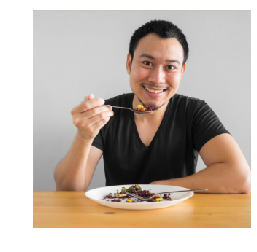

In [37]:
img = obtain_image(url="https://thecenterformindfuleating.org/resources/Pictures/asian%20man%20eating.jpg")
show_img(img)

a man with a shirt and a tie
a man sitting at a table with a plate of food
a man in a white shirt and tie with a fork .
a man with a shirt and a tie with a fork on a plate .
a man with a tie and a fork in front of a table .
a man in a red shirt and tie holding a fork .
a man in a white shirt and tie holding a fork .
a man with a tie and a fork in front of a table .
a man with a tie and a fork in front of a table .
a man with a tie and a tie


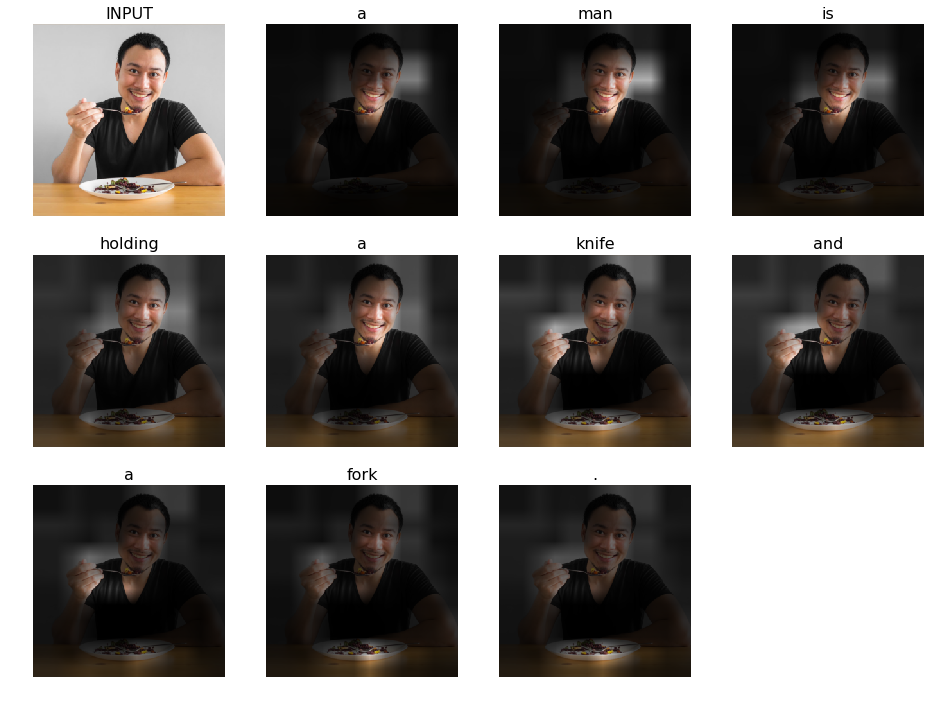

In [38]:
process_image(img)

a man riding a bike down a road with a man on his bike .
a man riding a bike on a road with a mountain on it
a man riding a bike on a bike path .
a man riding a bike on a road next to a mountain .
a man riding a bike down a road with a dog on the back .
a man riding a bike on a path in the middle of a mountain .
a man riding a bike on a road next to a mountain .
a man riding a bike on a path in the woods .
a person riding a bike on a road with a mountain in the background
a man riding a bike on a bike with a mountain .


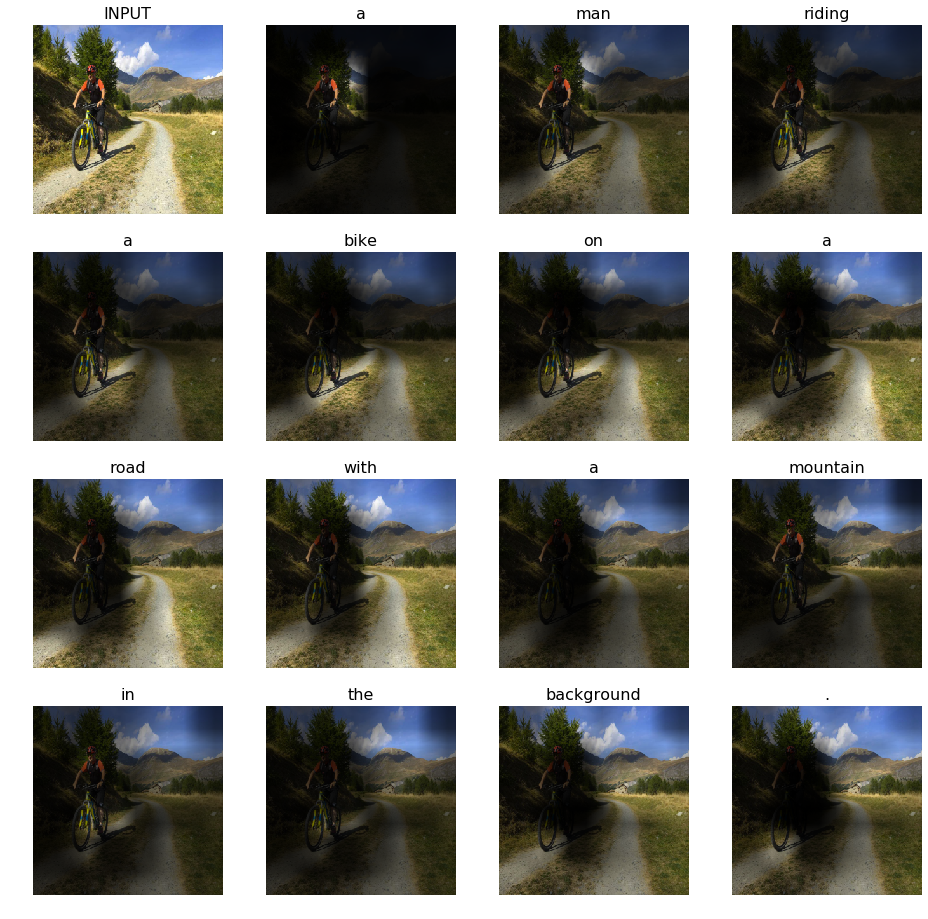

In [39]:
process_image(obtain_image(url="https://www.dimensioneattiva.it/wp-content/uploads/2016/10/Bike5.jpg"))

a cat that is laying on a couch
a cat that is laying down in the grass .
a cat that is laying down on a couch
a cat that is laying in a chair
a cat that is sitting on a chair
a cat is laying on a couch with a cat .
a cat that is laying down on a chair .
a cat sitting on a couch with a cat in its mouth .
a cat that is laying on a couch
a cat laying on top of a wooden floor .


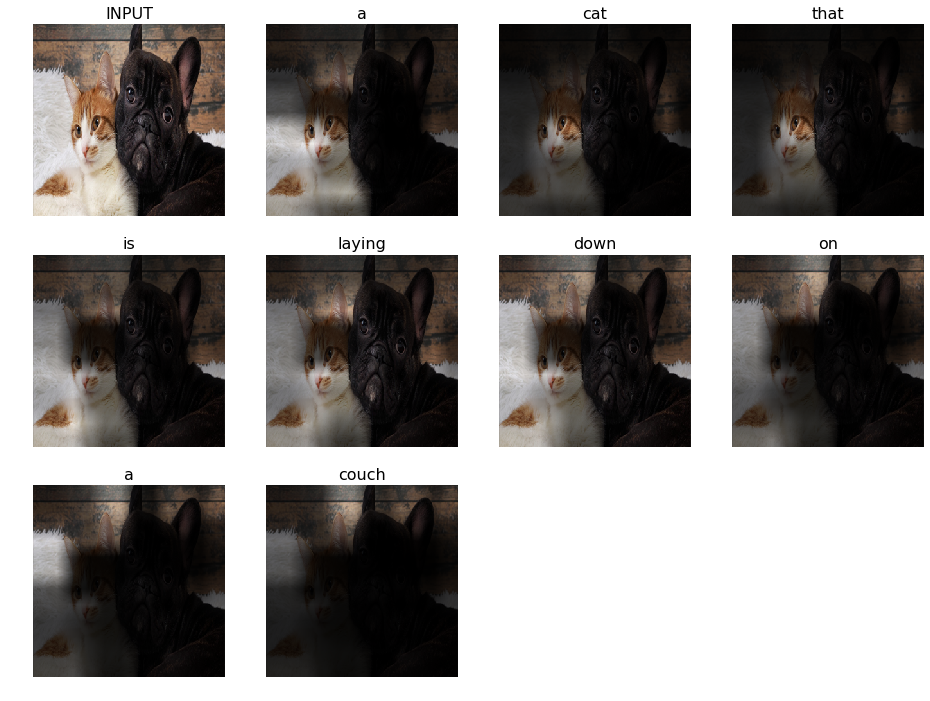

In [40]:
process_image(obtain_image(url="http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg"))

a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a skate board .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a skate board .


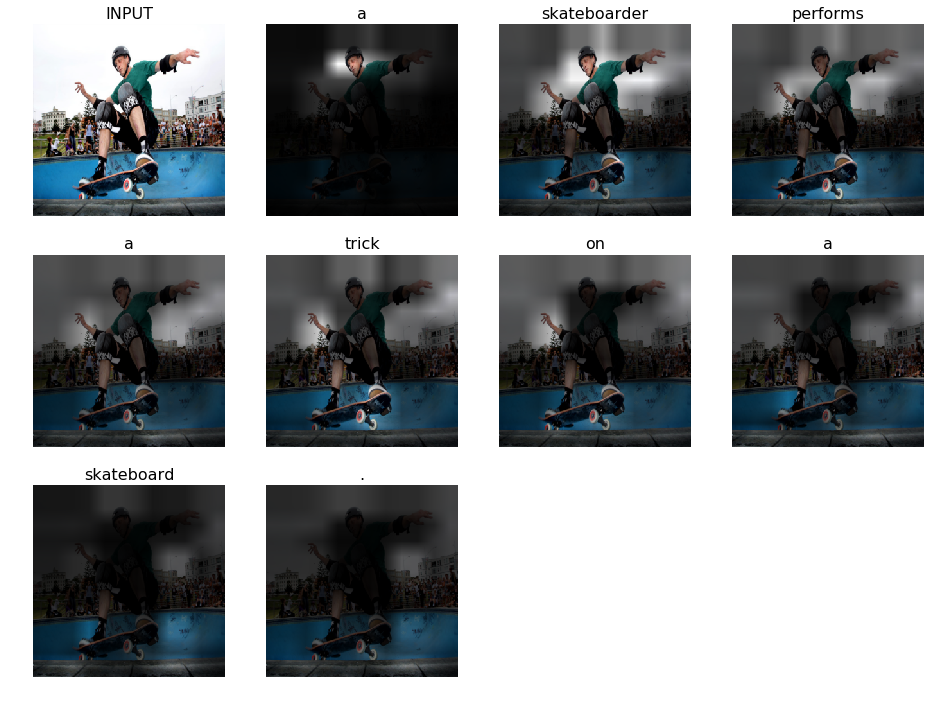

In [41]:
process_image(obtain_image(url="https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg"))

a bicycle leaning against a tree in the sand .
a bike is sitting on a beach with a surfboard .
a bike leaning against a tree and a tree .
a bike leaning against a tree on a beach .
a bike parked on a beach with a surfboard .
a bike parked on a beach with a surfboard in the background .
a bike parked on a beach with a person on the beach .
a bike is sitting on the beach by a bike .
a bike parked on a beach with a mountain in the background
a bicycle parked on a beach with a surfboard on the beach .


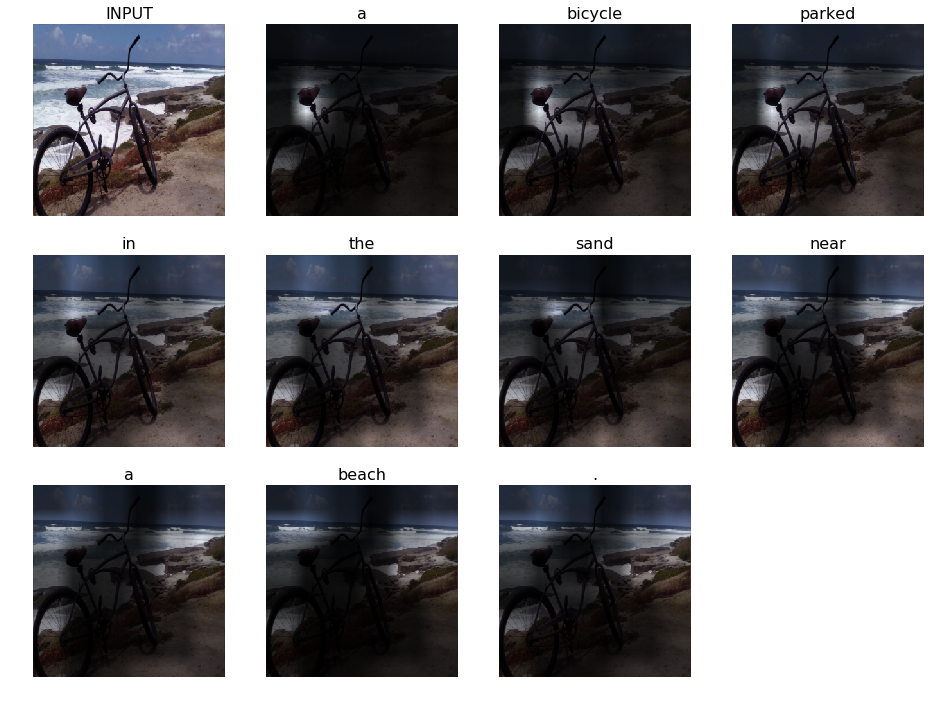

In [42]:
process_image(obtain_image(filename="/home/oleg/usa00/IMG_20190520_125121.jpg"))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [ ]:
#apply your network on image sample you found
#
#

### Conclusion
Here is a place for your conclusions, observations, hypotheses, and any other feedback.

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention over the generated part of the sentense.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563